In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = r"C:\Users\kayja\Documents\Music_NN\project\train"

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225]) 
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Alto Clef', 'Bass Clef', 'Eight', 'Half', 'Quarter', 'Sixteenth', 'Trebble Clef', 'Whole']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
# model

In [4]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 8),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay = 0.0006)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 1.534.. Test loss: 1.099.. Test accuracy: 0.577
Epoch 1/10.. Train loss: 0.906.. Test loss: 1.052.. Test accuracy: 0.477
Epoch 1/10.. Train loss: 0.629.. Test loss: 0.679.. Test accuracy: 0.746
Epoch 1/10.. Train loss: 0.536.. Test loss: 0.674.. Test accuracy: 0.741
Epoch 1/10.. Train loss: 0.444.. Test loss: 0.488.. Test accuracy: 0.802
Epoch 1/10.. Train loss: 0.404.. Test loss: 0.367.. Test accuracy: 0.865
Epoch 1/10.. Train loss: 0.353.. Test loss: 0.292.. Test accuracy: 0.889
Epoch 1/10.. Train loss: 0.235.. Test loss: 0.205.. Test accuracy: 0.940
Epoch 1/10.. Train loss: 0.305.. Test loss: 0.269.. Test accuracy: 0.891
Epoch 1/10.. Train loss: 0.276.. Test loss: 0.222.. Test accuracy: 0.928
Epoch 1/10.. Train loss: 0.225.. Test loss: 0.182.. Test accuracy: 0.943
Epoch 1/10.. Train loss: 0.186.. Test loss: 0.165.. Test accuracy: 0.945
Epoch 2/10.. Train loss: 0.238.. Test loss: 0.155.. Test accuracy: 0.949
Epoch 2/10.. Train loss: 0.229.. Test loss: 0.152..

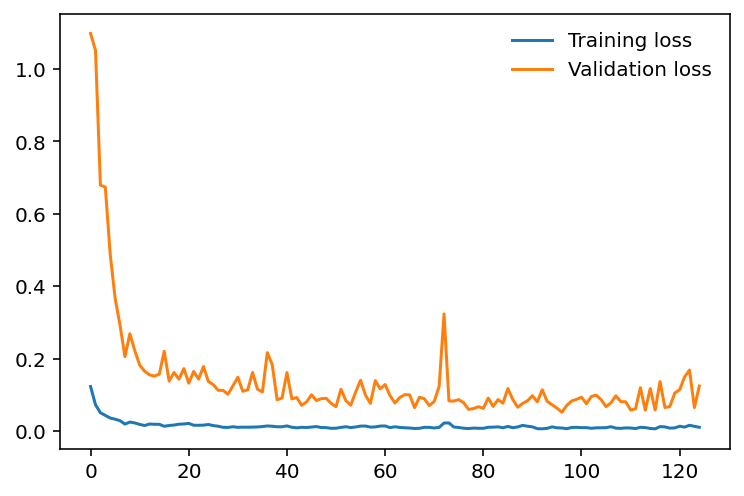

In [6]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [7]:
torch.save(model, "Music_Symbol_Identifier_Pytorch.pkl")